In [19]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
df = pd.read_csv("../Q1_clean.csv")
data = df.fillna(0)
data.head()

,Price,Review Scores Rating,Neighbourhood,Property Type,Room Type
0,549,96.0,Manhattan,Apartment,Private room
1,149,100.0,Brooklyn,Apartment,Entire home/apt
2,250,100.0,Manhattan,Apartment,Entire home/apt
3,90,94.0,Brooklyn,Apartment,Private room
4,270,90.0,Manhattan,Apartment,Entire home/apt


# EDA

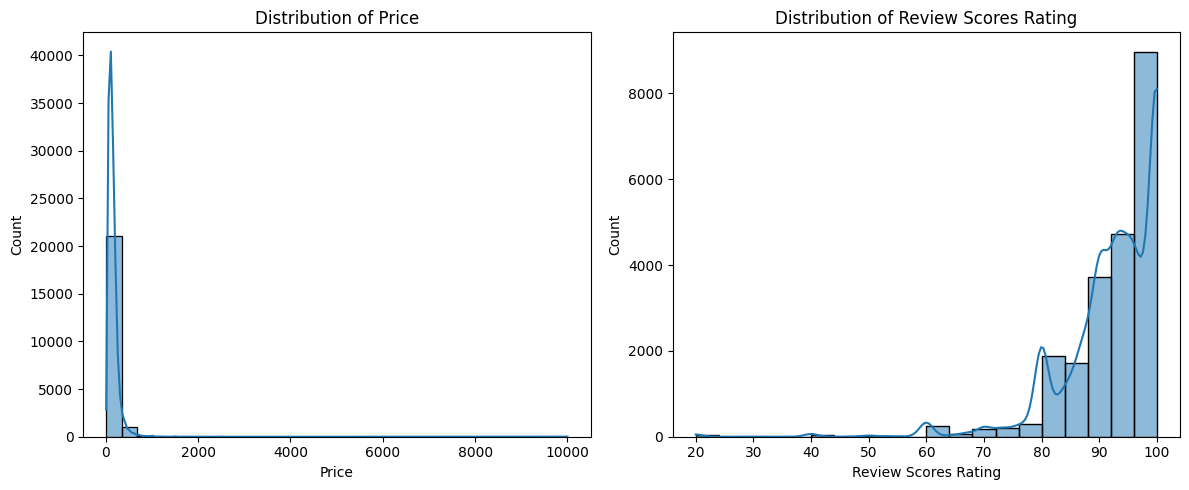

In [21]:
df.columns = df.columns.str.strip()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['Price'], bins=30, kde=True)
plt.title("Distribution of Price")

plt.subplot(1, 2, 2)
sns.histplot(df['Review Scores Rating'], bins=20, kde=True)
plt.title("Distribution of Review Scores Rating")
plt.tight_layout()
plt.show()

# Transform categorical variables 

In [22]:
#avg = data.groupby('Neighbourhood')[['Price', 'Review Scores Rating']].mean()

data.columns = data.columns.str.strip()
categorical_cols = ['Neighbourhood', 'Review Scores Rating', 'Property Type']
dummy = pd.get_dummies(data[categorical_cols], drop_first=True)
encode = pd.concat([data, dummy], axis = 1)
y = encode['Price']
X = dummy


# Train Test Split

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dummy, y, test_size = 0.2,random_state=5)

#help visualize stuff
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (17722, 22)
X_test shape: (4431, 22)
y_train shape: (17722,)
y_test shape: (4431,)


# Model building + performance comparsion

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

models = {
    'Neighbourhood Only': pd.get_dummies(data['Neighbourhood'], drop_first=True),
    'Property Type Only': pd.get_dummies(data['Property Type'], drop_first=True),
    'Room Type Only' : pd.get_dummies(data["Room Type"], drop_first=True),
    'Review Scores Rating Only': data[['Review Scores Rating']],
    'All Combined': pd.get_dummies(data[['Neighbourhood', 'Property Type', 'Room Type', 'Review Scores Rating']], drop_first=True)
}

results = []

for model_name, features in models.items():

    # redo train test split
    X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=5)
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    
    y_train_pred = reg.predict(X_train)
    y_test_pred = reg.predict(X_test)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    results.append({
        'Model': model_name,
        'Train RMSE': round(train_rmse, 2),
        'Test RMSE': round(test_rmse, 2),
        'Train R^2': round(train_r2, 3),
        'Test R^2': round(test_r2, 3)
    })

results_df = pd.DataFrame(results)
print(results_df)

                       Model  Train RMSE  Test RMSE  Train R^2  Test R^2
0         Neighbourhood Only      150.01     125.01      0.043     0.065
1         Property Type Only      152.93     128.84      0.005     0.007
2             Room Type Only      142.02     116.36      0.142     0.190
3  Review Scores Rating Only      153.10     128.86      0.003     0.007
4               All Combined      139.05     112.65      0.178     0.241


# Correlation Plots

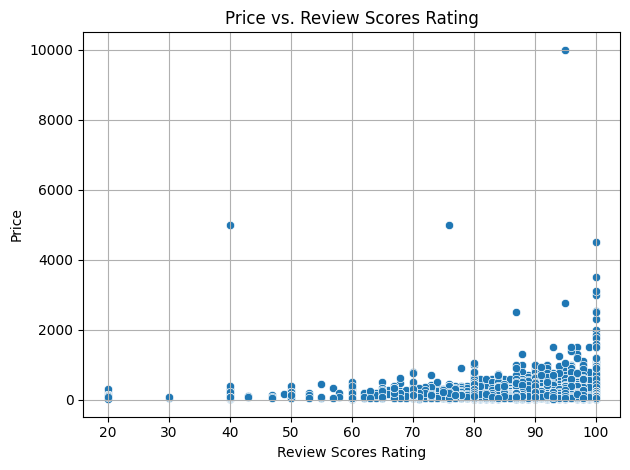

In [25]:
sns.scatterplot(data=data, x='Review Scores Rating', y='Price')
plt.title('Price vs. Review Scores Rating')
plt.xlabel('Review Scores Rating')
plt.ylabel('Price')
plt.grid(True)
plt.tight_layout()
plt.show()

# Complex Model Transformation

In [29]:
from sklearn.preprocessing import PolynomialFeatures

X_dummies = pd.get_dummies(data[["Neighbourhood", "Property Type", "Room Type"]], dtype = "int", drop_first = True)
X1 = pd.concat([data["Review Scores Rating"], X_dummies], axis = 1)

# Adds squared terms and interactions between features
expander = PolynomialFeatures(degree = 2, include_bias = False)
Z = expander.fit_transform(X1.iloc[:, :])
names = expander.get_feature_names_out()

X = pd.DataFrame(data = Z, columns = names)
y = df["Price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 5)

reg = LinearRegression(fit_intercept = True).fit(X_train, y_train)
results = pd.DataFrame({'variable' : reg.feature_names_in_, 'coefficient' : reg.coef_})

y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)
train_rmse = np.sqrt(np.mean((y_train - y_pred_train) ** 2))
test_rmse = np.sqrt(np.mean((y_test - y_pred_test) ** 2))

print("Train RMSE: ", round(train_rmse, 4))
print("R-Squared on Train: ", round(reg.score(X_train, y_train), 4))
print()
print("Test RMSE: ", round(test_rmse, 4))
print("R-Squared on Test: ", round(reg.score(X_test, y_test), 4))
print()
print("Best Simple Model Test RMSE: ", round(results_df.sort_values(by = "Test R^2", ascending = False).iloc[0, 2], 4))
print("Best Simple Model Test R^2: ", round(results_df.sort_values(by = "Test R^2", ascending = False).iloc[0, 4], 4))

Train RMSE:  135.6403
R-Squared on Train:  0.2175

Test RMSE:  112.2396
R-Squared on Test:  0.2465

Best Simple Model Test RMSE:  112.65
Best Simple Model Test R^2:  0.241


**The more complex model performs much better than some of the simpler models, but compared to the best of the "simple" models, the difference in performance ranges from negligible to small depending on the randoms state.**

## Summary

# Optional Lasso Regularization 